In [132]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.remote.webelement import WebElement
from selenium.webdriver.remote.webdriver import WebDriver
from webdriver_manager.chrome import ChromeDriverManager
from dataclasses import dataclass
from functools import reduce
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


@dataclass
class VisualBlock:
    tag: list[str]
    x: int
    y: int
    w: int
    h: int


class VisualBlocksGenerator:
    def __init__(self) -> None:
        try:
            op = webdriver.ChromeOptions()
            op.add_argument('headless')
            self.driver = webdriver.Chrome(service=Service(
                ChromeDriverManager().install()), options=op)
            self.driver.set_window_position(0, 0)
            self.driver.set_window_size(1920, 1080)
            self.is_destroyed = False
        except:
            self.is_destroyed = True

    def quit(self) -> None:
        self.driver.quit()
        self.is_destroyed = True

    def generate(self, url: str) -> list[VisualBlock]:
        if self.is_destroyed:
            return []

        try:
            self.driver.get(url)
        except:
            return []

        elements = self.driver.find_elements(By.XPATH, "/*")

        return list(reduce(lambda list, element: list + self.__visit_element(element), elements, []))

    def __visit_element(self, element: WebElement) -> list[VisualBlock]:
        currentBlock = self.__parse_element_to_visual_block(element)
        children = element.find_elements(By.XPATH, "./*")

        return [currentBlock] + list(reduce(lambda list, child: list + self.__visit_element(child), children, []))

    def __parse_element_to_visual_block(self, element: WebElement) -> VisualBlock:
        w, h = element.size['width'], element.size['height']
        x, y = element.location['x'], element.location['y']
        tag = [element.tag_name]

        return VisualBlock(tag, x, y, w, h)


In [13]:
generator = VisualBlocksGenerator()

In [14]:
li = generator.generate("https://www.google.com/")

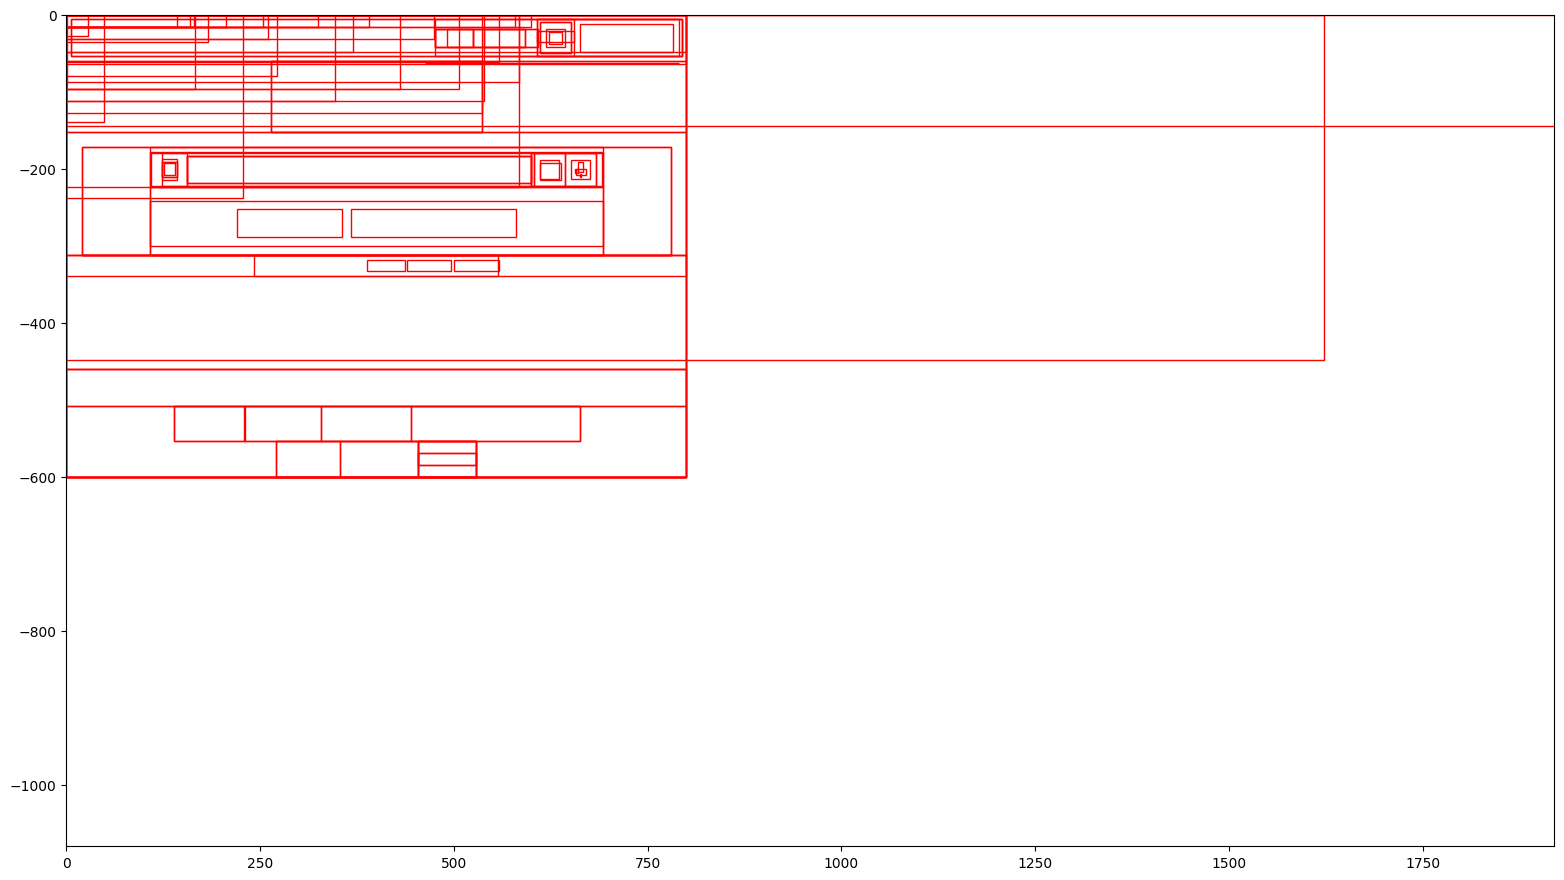

In [145]:
def sketch_visual_blocks(blocks: list[VisualBlock]):
    fig, ax = plt.subplots(figsize=(19.2, 10.8))
    plt.xlim([0, 1920])
    plt.ylim([-1080, 0])

    for i in blocks:
        ax.add_patch(Rectangle((i.x, -i.h-i.y), i.w, i.h, edgecolor='red',
                               facecolor='none', lw=1))

    plt.show()

sketch_visual_blocks(li)

In [111]:
class LayoutComparator:
    def __init__(self, x_threshold: float = 40.0, y_threshold: float = 40.0, w_threshold: float = 40.0, h_threshold: float = 40.0, block_threshold: float = 40.0) -> None:
        self.x_threshold = x_threshold
        self.y_threshold = y_threshold
        self.w_threshold = w_threshold
        self.h_threshold = h_threshold
        self.block_threshold = block_threshold

    def __merge_block_to_list(self, list: list[VisualBlock], block: VisualBlock) -> list[VisualBlock]:
        if len(list) == 0:
            return [block]

        last = list[-1]
        if last.y == block.y and last.h == block.h:
            new_x = min(last.x, block.x)
            new_w = max(last.x + last.w, block.x + block.w) - new_x
            new_tag = last.tag + block.tag
            list[-1].x, list[-1].w, list[-1].tag = new_x, new_w, new_tag

            return list

        list.append(block)
        return list

    def merge(self, blocks: list[VisualBlock]) -> list[VisualBlock]:
        new_blocks = deepcopy(blocks)
        new_blocks.sort(key=lambda block: (block.y, block.h, block.x, block.w))
        new_blocks = list(reduce(self.__merge_block_to_list, new_blocks, []))

        return new_blocks

    def compare(self, blocks_1: list[VisualBlock], blocks_2: list[VisualBlock]) -> float:
        merged_blocks_1 = self.merge(blocks_1)
        merged_blocks_2 = self.merge(blocks_2)
        n_1 = len(merged_blocks_1)
        n_2 = len(merged_blocks_2)

        # sum_bs = 0
        # n_similar = 0
        # for block_1 in merged_blocks_1:
        #     for block_2 in merged_blocks_2:
        #         x_similarity = (block_1.x - block_2.x) / self.x_threshold
        #         y_similarity = (block_1.y - block_2.y) / self.y_threshold
        #         w_similarity = (block_1.w - block_2.w) / self.w_threshold
        #         h_similarity = (block_1.h - block_2.h) / self.h_threshold
        #         block_similarity = (
        #             x_similarity + y_similarity + w_similarity + h_similarity) / 4
        #         sum_bs += block_similarity
        #         if block_similarity <= self.block_threshold:
        #             n_similar += 1

        # layout_similarity = (sum_bs / n_similar) * (2 * n_similar / (n_1 + n_2))
        # return layout_similarity

        sum_bs = 0
        n_similar = 0
        for block_1 in merged_blocks_1:
            for block_2 in merged_blocks_2:
                is_x_similar = abs(block_1.x - block_2.x) < self.x_threshold
                is_y_similar = abs(block_1.y - block_2.y) < self.y_threshold
                is_w_similar = abs(block_1.w - block_2.w) < self.w_threshold
                is_h_similar = abs(block_1.h - block_2.h) < self.h_threshold

                if is_x_similar and is_y_similar and is_w_similar and is_h_similar:
                    n_similar += 1

        layout_similarity = n_similar / (n_1 + n_2)
        return layout_similarity


In [112]:
generator = VisualBlocksGenerator()
comparator = LayoutComparator()


In [113]:
web_1 = generator.generate("https://www.google.com/")

In [114]:
web_2 = generator.generate("https://www.geeksforgeeks.org/")

In [115]:
web_3 = generator.generate("https://www.bing.com/")

In [116]:
web_4 = generator.generate("https://www.facebook.com/")

In [117]:
web_5 = generator.generate("https://www.instagram.com/")

In [150]:
print(comparator.compare(web_5, web_1))


0.08256880733944955


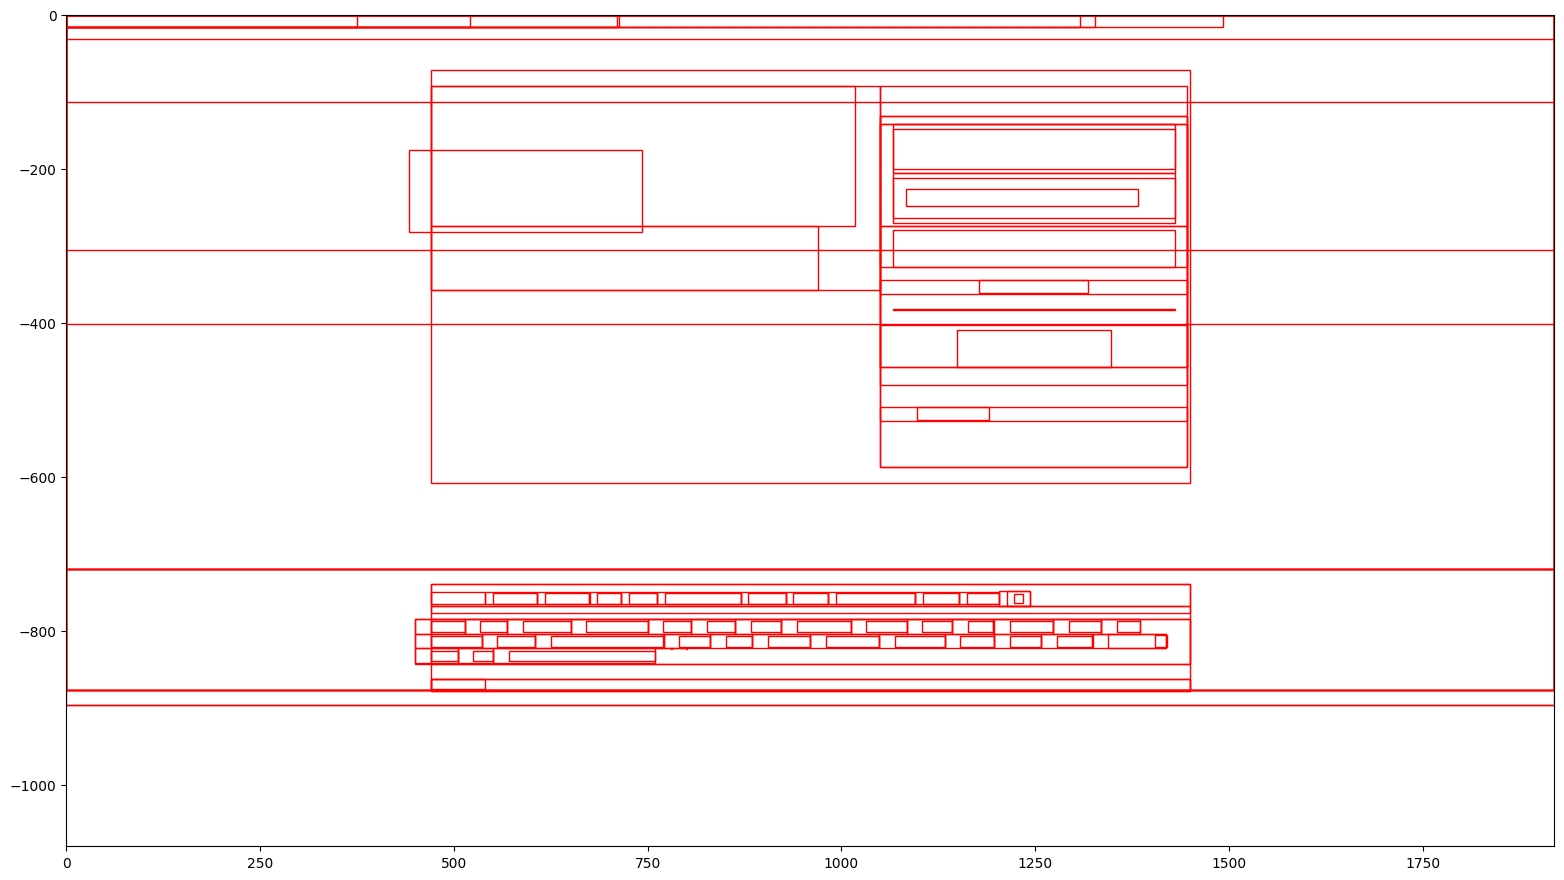

In [152]:
sketch_visual_blocks(web_4)

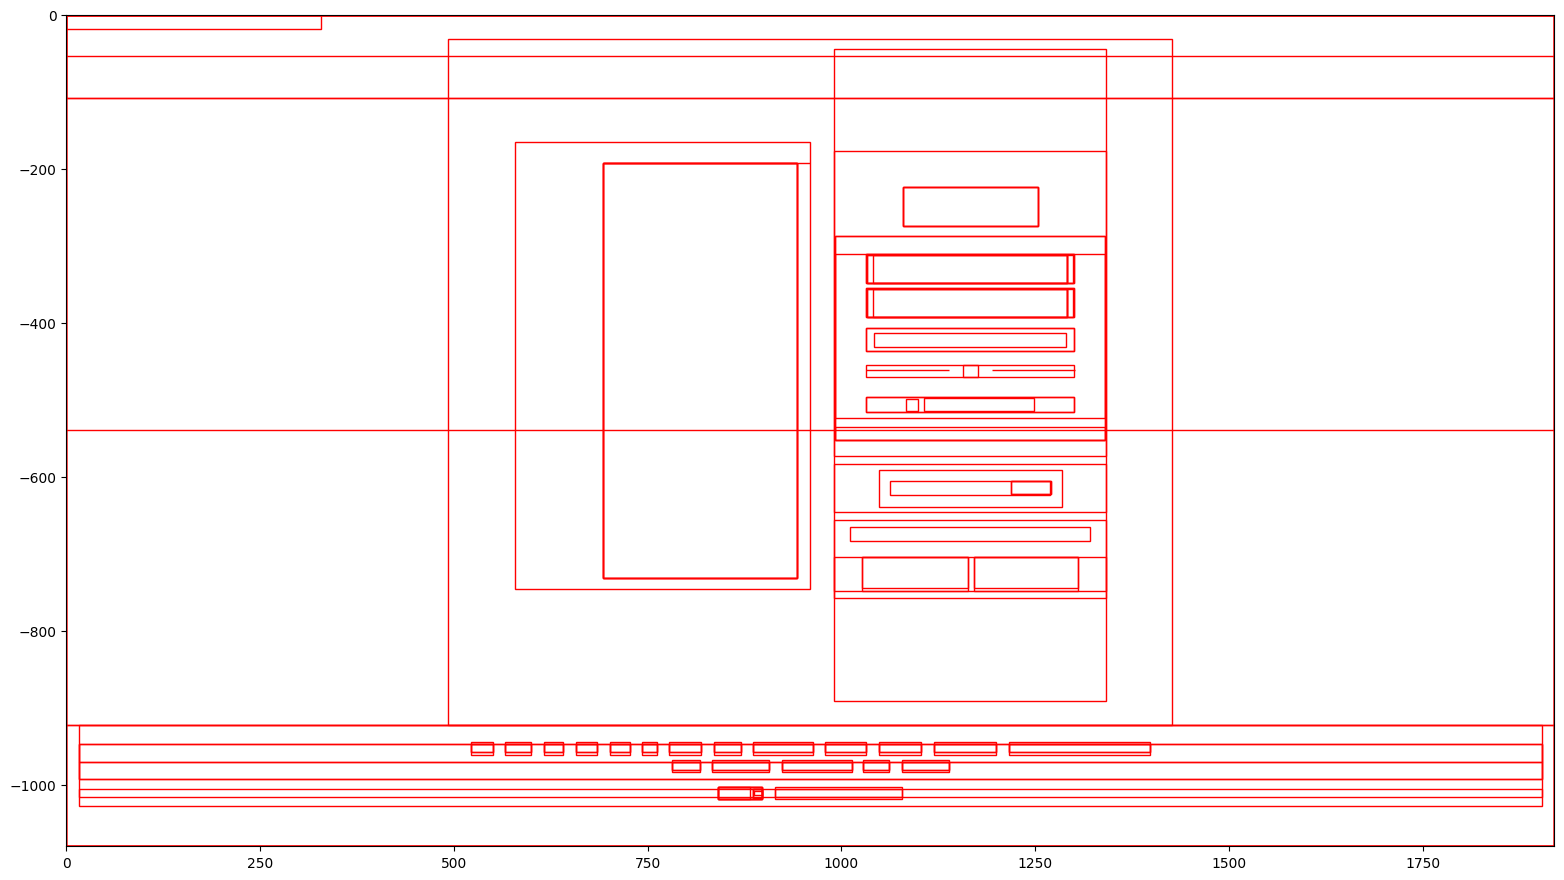

In [146]:
sketch_visual_blocks(web_5)

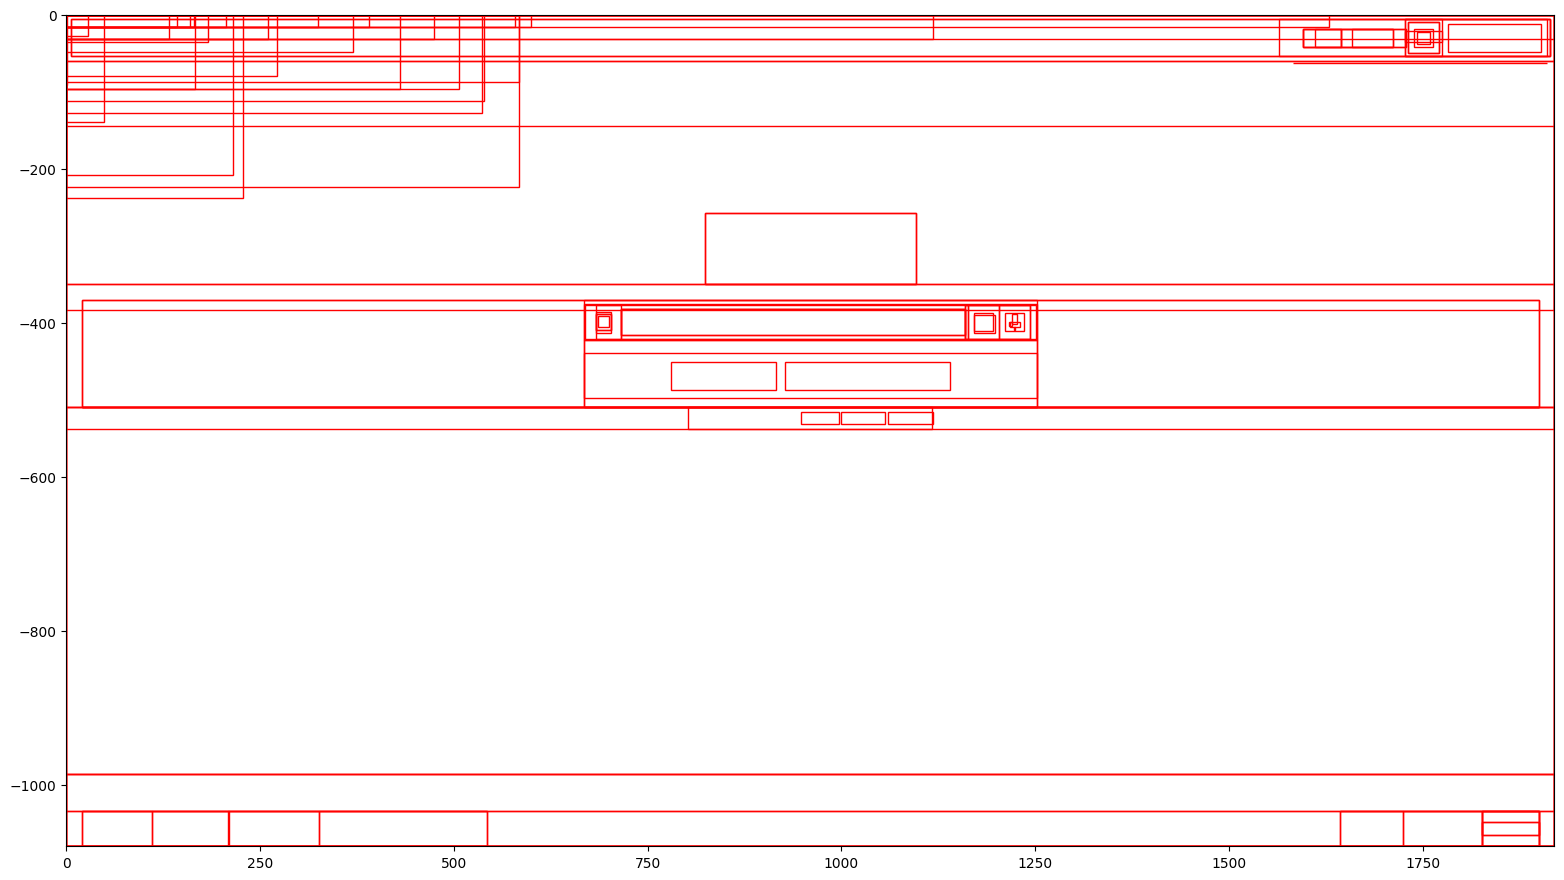

In [151]:
sketch_visual_blocks(web_1)